# Introduction: Digital Controller Design

In this section we will discuss converting continuous time models into discrete time (or difference equation) models. We will also introduce the z-transform and show how to use it to analyze and design controllers for discrete time systems.

## Introduction

The figure below shows the typical continuous feedback system that we have been considering so far in this tutorial. Almost all of the continuous controllers can be built using analog electronics.
![block1.png](figures/block1.png)
The continuous controller, enclosed in the dashed square, can be replaced by a digital controller, shown below, that performs same control task as the continuous controller. The basic difference between these controllers is that the digital system operates on discrete signals (or samples of the sensed signal) rather than on continuous signals.
![block2.png](figures/block2.png)
Different types of signals in the above digital schematic can be represented by the following plots.
![signals.png](figures/signals.png)
The purpose of this Digital Control Tutorial is to show you how to use Python to work with discrete functions either in transfer function or state-space form to design digital control systems.

### Zero-Hold Equivalence

In the above schematic of the digital control system, we see that the digital control system contains both discrete and the continuous portions. When designing a digital control system, we need to find the discrete equivalent of the continuous portion so that we only need to deal with discrete functions. For this technique, we will consider the following portion of the digital control system and rearrange as follows.
![block3.png](figures/block3.png)

![block4.png](figures/block4.png)
The **clock** connected to the *D/A and A/D converters* supplies a pulse every T seconds and each D/A and A/D sends a signal only when the pulse arrives. The purpose of having this pulse is to require that Hzoh(z) have only samples u(k) to work on and produce only samples of output y(k); thus, Hzoh(z) can be realized as a discrete function. The philosophy of the design is the following. We want to find a discrete function Hzoh(z) so that for a piecewise constant input to the continuous system H(s), the sampled output of the continuous system equals the discrete output. Suppose the signal u(k) represents a sample of the input signal. There are techniques for taking this sample u(k) and holding it to produce a continuous signal uhat(t). The sketch below shows that the uhat(t) is held constant at u(k) over the interval kT to (k+1)T. This operation of holding uhat(t) constant over the sampling time is called zero-order hold.
![zohfig.png](figures/zohfig.png)
The zero-order held signal uhat(t) goes through H2(s) and A/D to produce the output y(k) that will be the piecewise same signal as if the discrete signal u(k) goes through Hzoh(z) to produce the discrete output y(k).
![block7.png](figures/block7.png)
Now we will redraw the schematic, placing Hzoh(z) in place of the continuous portion.
![block6.png](figures/block6.png)
By placing Hzoh(z), we can design digital control systems dealing with only discrete functions. *Note:* There are certain cases where the discrete response does not match the continuous response due to a hold circuit implemented in digital control systems. For information, see Lagging effect associated with the hold.

### Conversion Using c2d

There is a control toolbox function called `control.c2d` that converts a given continuous system (either in transfer function or state-space form) to a discrete system using the zero-order hold operation explained above.

The sampling time (Ts in sec/sample) should be smaller than 1/(30*BW), where BW is the closed-loop bandwidth frequency.

## Example: Mass-Spring-Damper

### Transfer Function

Suppose you have the following continuous transfer function

$$
\frac{X(s)}{F(s)} = \frac{1}{Ms^2+bs+k}
$$

Assuming the closed-loop bandwidth frequency is greater than 1 rad/sec, we will choose the sampling time (Ts) equal to 1/100 sec. Now, create an new m-file and enter the following commands.

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Latex, Math, display

s = control.TransferFunction.s

In [2]:
%matplotlib inline
# Generate Larger more readable plots
# Double click on images to make them full scale.
sns.set(
    rc={
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "figure.figsize": (4 * 1.618, 4),
        "figure.dpi": 200,
    }
)

In [3]:
M = 1
b = 10
k = 20
sys = 1 / (M * s ** 2 + b * s + k)

display(Math("$$\\frac{X(s)}{F(s)}=" + sys._repr_latex_().lstrip("$")))

<IPython.core.display.Math object>

In [4]:
Ts = 1 / 100
sys_d = control.c2d(sys, Ts, "zoh")
display(Math("$$ \\frac{X(z)}{F(z)} = " + sys_d._repr_latex_().lstrip("$")))

<IPython.core.display.Math object>

### State-Space

The continuous time state-space model is as follows:

$$
\mathbf{\dot{x}} = \left[ \begin{array}{c} \dot{x} \\ \ddot{x} \end{array} \right] = \left[ \begin{array}{cc} 0 & 1 \\ -\frac{k}{m}  & -\frac{b}{m} \end{array} \right] \left[ \begin{array}{c} x \\ \dot{x} \end{array} \right] + \left[ \begin{array}{c} 0 \\ \frac{1}{m} \end{array} \right] F(t)
$$



$$
y = \left[ \begin{array}{cc} 1 & 0 \end{array} \right] \left[ \begin{array}{c} x \\ \dot{x} \end{array} \right]
$$

All constants are the same as before.  The following m-file converts the above continuous state-space to discrete state-space.

In [5]:
A = np.array([[0, 1], [-k / M, -b / M]])
B = np.array([[0], [1 / M]])
C = np.array([[1, 0]])
D = np.array([[0]])
Ts = 1 / 100
sys = control.ss(A, B, C, D)
sys

StateSpace(array([[  0.,   1.],
       [-20., -10.]]), array([[0.],
       [1.]]), array([[1., 0.]]), array([[0.]]))

In [6]:
sys_d = control.c2d(sys, Ts, "zoh")
sys_d

StateSpace(array([[ 0.99903268,  0.00951309],
       [-0.19026174,  0.90390181]]), array([[4.83661727e-05],
       [9.51308696e-03]]), array([[1., 0.]]), array([[0.]]), 0.01)

From these matrices, the discrete state-space can be written as

$$
\left[ \begin{array}{c} x(k) \\ v(k) \end{array} \right] = \left[ \begin{array}{cc} 0.9990 & 0.0095 \\ -0.1903 & 0.9039  \end{array} \right] \left[ \begin{array}{c} x(k-1) \\ v(k-1) \end{array} \right] + \left[ \begin{array}{c} 0 \\ 0.0095 \end{array} \right] F(k-1)
$$



$$
y(k-1) = \left[ \begin{array}{cc} 1 & 0 \end{array} \right] \left[ \begin{array}{c} x(k-1) \\ v(k-1) \end{array} \right]
$$

Now you have the discrete time state-space model.

### Stability and Transient Response

For continuous systems, we know that certain behaviors results from different pole locations in the s-plane. For instance, a system is unstable when any pole is located to the right of the imaginary axis. For discrete systems, we can analyze the system behaviors from different pole locations in the z-plane. The characteristics in the z-plane can be related to those in the s-plane by the expression

$$
z = e^{sT}
$$


* T = Sampling time (sec/sample)
* s = Location in the s-plane
* z = Location in the z-plane The figure below shows the mapping of lines of constant damping ratio (zeta) and natural frequency (Wn) from the s-plane to the z-plane using the expression shown above.
![zgrid.gif](figures/zgrid.gif)
If you noticed in the z-plane, the stability boundary is no longer imaginary axis, but is the unit circle |z|=1. The system is stable when all poles are located inside the unit circle and unstable when any pole is located outside. For analyzing the transient response from pole locations in the z-plane, the following three equations used in continuous system designs are still applicable.

$$
\zeta \omega_n \geq \frac{4.6}{Ts}
$$



$$
\omega_n \geq \frac{1.8}{Tr}
$$



$$
\zeta = \frac{-\ln(\%OS/100)}{\sqrt{\pi^2+\ln(\%OS/100)^2}}
$$

where,

- $\zeta$ = Damping ratio
- $\omega_n$ = natural frequency (rad/sec)
- $T_s$ = 1% settling time
- $T_r$ = 10-90% rise time
- $M_p$ = maximum overshoot


**Important**: The natural frequency (Wn) in z-plane has the unit of rad/sample, but when you use the equations shown above, the Wn must be in the unit of rad/sec. Suppose we have the following discrete transfer function

$$
\frac{Y(z)}{F(z)} = \frac{1}{z^2-0.3z+0.5}
$$

Create an new m-file and enter the following commands. Running this m-file in the command window gives you the following plot with the lines of constant damping ratio and natural frequency.

In [7]:
numDz = [1]
denDz = [1, -0.3, 0.5]
sys = control.TransferFunction(numDz, denDz, -1)
sys

TransferFunction(array([1]), array([ 1. , -0.3,  0.5]))

(-1.0, 1.0, -1.0, 1.0)

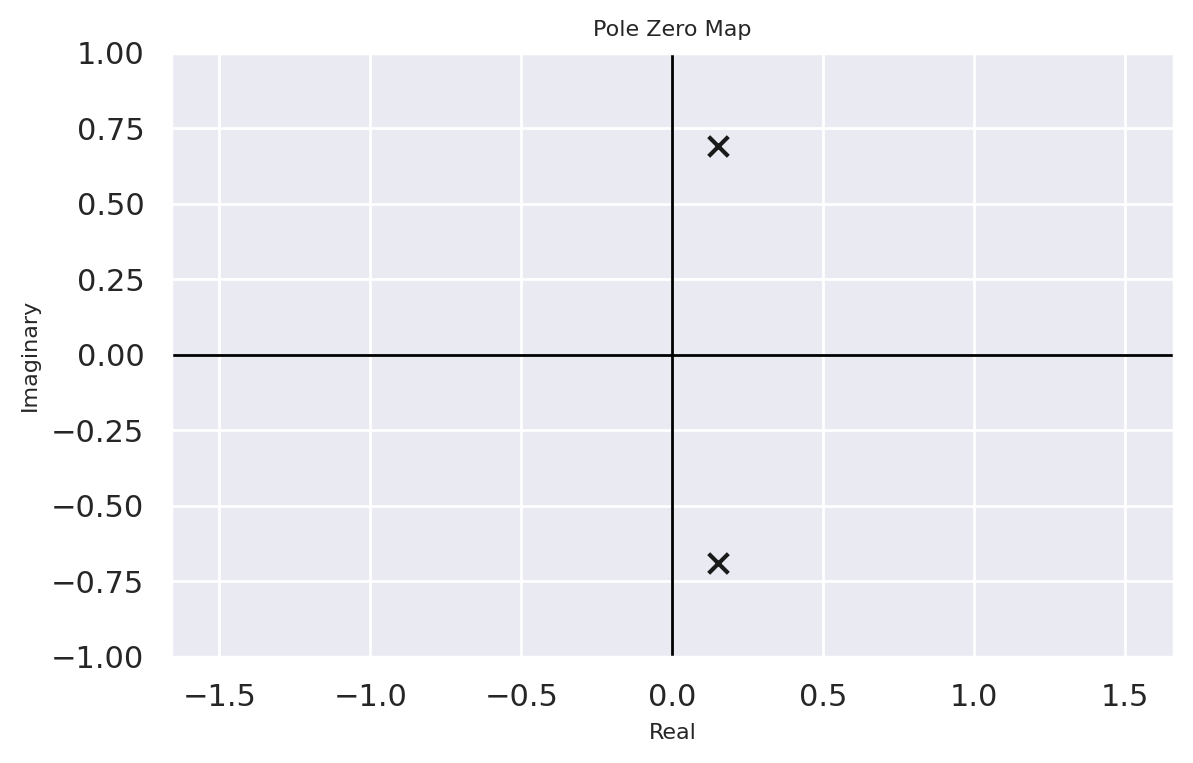

In [8]:
poles, zeros = control.pzmap(sys)
plt.gca().axis([-1, 1, -1, 1])

From this plot, we see poles are located approximately at the natural frequency of $\frac{9\pi}{20T}$ (rad/sample) and the damping ratio of 0.25. Assuming that we have a sampling time of 1/20 sec (which leads to Wn = 28.2 rad/sec) and using three equations shown above, we can determine that this system should have the rise time of 0.06 sec, a settling time of 0.65 sec and a maximum overshoot of 45% (0.45 more than the steady-state value). Let's obtain the step response and see if these are correct. Add the following commands to the above cell and rerun it in the notebook. You should get the following step response.

In [9]:
sys = control.TransferFunction(numDz, denDz, 1 / 20)
sys

TransferFunction(array([1]), array([ 1. , -0.3,  0.5]), 0.05)

Text(0.5, 1.0, 'Step Response')

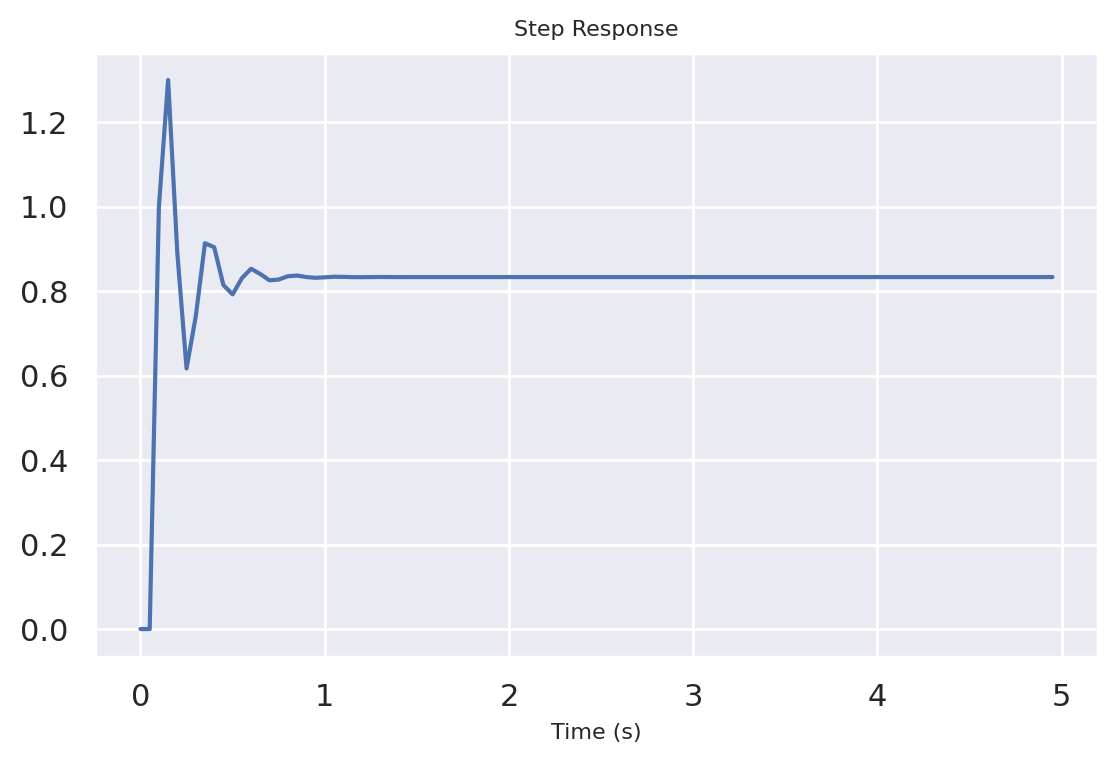

In [10]:
T, yout = control.step_response(sys=sys)

plt.plot(T, yout)
plt.xlabel("Time (s)")
plt.title("Step Response");

As you can see from the plot, the rise time, settling time and overshoot came out to be what we expected. This shows how you can use the locations of poles and the above three equations to analyze the transient response of the system.

## Discrete Root Locus

The root-locus is the locus of points where roots of characteristic equation can be found as a single gain is varied from zero to infinity. The characteristic equation of an unity feedback system is

$$
1+KG(z)Hzoh(z) = 0
$$

where G(z) is the compensator implemented in the digital controller and Hzoh(z) is the plant transfer function in z. The mechanics of drawing the root-loci are exactly the same in the z-plane as in the s-plane. Recall from the continuous Root-Locus Tutorial, we used the Python function called sgrid to find the root-locus region that gives an acceptable gain (K). For the discrete root-locus analysis, we will use the function zgrid that has the same characteristics as sgrid. The command zgrid(zeta, Wn) draws lines of constant damping ratio (zeta) and natural frequency (Wn). Suppose we have the following discrete transfer function

$$
\frac{Y(z)}{F(z)} = \frac{z-0.3}{z^2-1.6z+0.7}
$$

and the requirements are a damping ratio greater than 0.6 and a natural frequency greater than 0.4 rad/sample (these can be found from design requirements, sampling time (sec/sample) and three equations shown in the previous section). The following commands draw the root-locus with the lines of constant damping ratio and natural frequency. Create an new m-file and enter the following commands. Running this m-file should give you the following root-locus plot.

In [11]:
numDz = [1, -0.3]
denDz = [1, -1.6, 0.7]
sys = control.TransferFunction(numDz, denDz, -1)
rlist, klist = control.rlocus(sys)

ValueError: Image size of 5895002x763 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1294.4x800 with 1 Axes>

From this plot, we can see that the system is stable for some values of $K$ since there are portions of the root locus where both branches are located inside the unit circle. Also, we can observe two dotted lines representing the constant damping ratio and natural frequency. The natural frequency is greater than 0.3 outside the constant-Wn line, and the damping ratio is greater than 0.4 inside the constant-zeta line. In this example, portions of the generated root-locus are within in the desired region. Therefore, a gain ($K$) chosen to place the two closed-loop poles on the loci within the desired region should provide us a response that satisfies the given design requirements. 